# Compare CPL hist. file and table against MOM6

This notebooks compares the yearly averages from the MOM6 history file agains the budget table generated by the coupler.

### case: bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001
This is a 2-year run using sandbox cesm2_3_beta08.sbx and CESM/MOM6 PR https://github.com/NCAR/MOM6/pull/214

**from Mariana:**

We now have a new CMEPS tag on master that has the enthalpy changes.
To get the new code you should check out cesm2_3_beta08

> git clone https://github.com/ESCOMP/cesm
> cd cesm
> git checkout cesm2_3_beta08

Then do the following:
1) edit the Externals.cfg to have the following change for CMEPS:

[cmeps]
tag = cmeps0.13.53
protocol = git
repo_url = https://github.com/ESCOMP/CMEPS.git
local_path = components/cmeps
required = True

2) edit the Externals.cfg to point to have mom use MOM6 externals point to your branch (gustavo/enthalpy_coupler) 

In [33]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot

In [2]:
path= '/glade/scratch/gmarques/bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001/run/'
grd = MOM6grid(path+'bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001.mom6.static.nc')
area = np.ma.masked_where(grd.wet==0,grd.area_t)
grd_xr = MOM6grid(path+'bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001.mom6.static.nc', xrformat=True)

C_P = 3992.0 
latent_heat_fusion = 3.337E+05
latent_heat_vapor = 2.501E+06

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



### Load data 

In [3]:
ds_mom =  xr.open_mfdataset(path+'bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001.mom6.frc_000?.nc')

/glade/work/gmarques/miniconda/envs/dev/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
print('Times: ',ds_mom.time.values[:])

Times:  [cftime.DatetimeNoLeap(1, 7, 2, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2, 7, 2, 12, 0, 0, 0, has_year_zero=True)]


In [5]:
ds_sfc =  xr.open_mfdataset(path+'bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001.mom6.sfc_000?.nc')

In [6]:
ds_cpl = xr.open_dataset(path+'bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001.cpl.hi.0002-12-31-00000.nc')

In [7]:
ds_cpl.time.values

array([cftime.DatetimeNoLeap(2, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

### Areas

In [10]:
n=0
# areas
#earth_rad = 6.37122e6 # in m (from shr_constants)
earth_rad = 6.378e6 # in m (from MOM6)

model_area = grd.area_t / (earth_rad**2)
med_area = ds_cpl.MED_ocn_area[n,:].values
#med_area = ds_cpl.MED_ocn_area[n,:].values

#med2mod_areacor = med_area/model_area
#mod2med_areacor = model_area/med_area

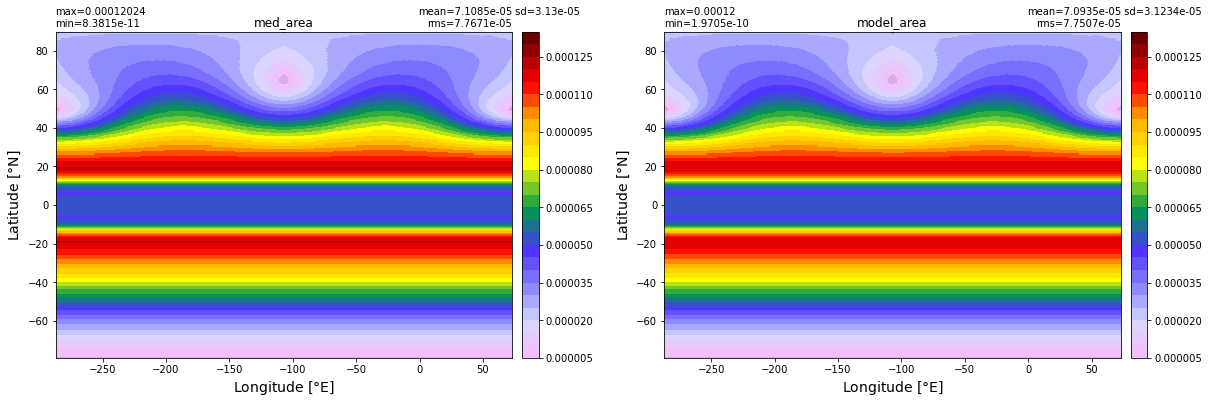

In [11]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax1 = ax.flatten()

xyplot(med_area,grd.geolon, grd.geolat, grd.area_t, axis=ax1[0], title='med_area')
xyplot(model_area,grd.geolon, grd.geolat, grd.area_t, axis=ax1[1], title='model_area')


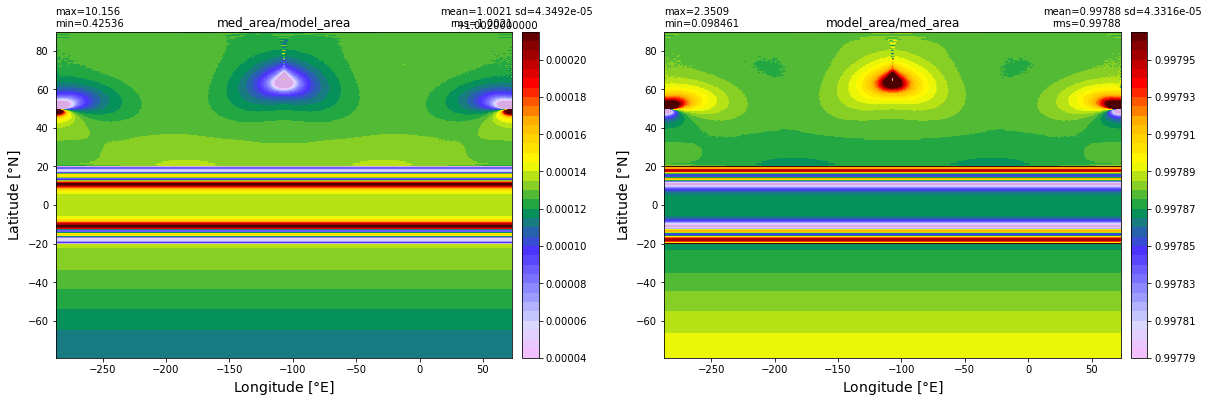

In [12]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax1 = ax.flatten()

#med2mod_areacor = np.ma.masked_where(grd.wet==0,med_area/model_area)
#mod2med_areacor = np.ma.masked_where(grd.wet==0,model_area/med_area)

med2mod_areacor = med_area/model_area
mod2med_areacor = model_area/med_area

xyplot(med2mod_areacor,grd.geolon, grd.geolat, area, axis=ax1[0], title='med_area/model_area')
xyplot(mod2med_areacor,grd.geolon, grd.geolat, area, axis=ax1[1], title='model_area/med_area')


In [14]:
n=1
print(ds_mom.time[n].values)
net_heat_surface = np.nan_to_num(ds_mom.net_heat_surface[n,:].values) * mod2med_areacor
net_heat_coupler1 = np.nan_to_num(ds_mom.net_heat_coupler[n,:].values)* mod2med_areacor
sensible = np.nan_to_num(ds_mom.sensible[n,:].values)* mod2med_areacor
latent = np.nan_to_num(ds_mom.latent[n,:].values)* mod2med_areacor
SW = np.nan_to_num(ds_mom.SW[n,:].values)* mod2med_areacor
LW = np.nan_to_num(ds_mom.LW[n,:].values)* mod2med_areacor
Heat_PmE = np.nan_to_num(ds_mom.Heat_PmE[n,:].values)* mod2med_areacor
seaice_melt_heat = np.nan_to_num(ds_mom.seaice_melt_heat[n,:].values)* mod2med_areacor
net_heat_coupler2 = sensible + latent + SW + LW + seaice_melt_heat
frazil = np.nan_to_num(ds_mom.frazil[n,:].values)* mod2med_areacor
latent_evap= np.nan_to_num(ds_mom.latent_evap[n,:].values)* mod2med_areacor
latent_fprec_diag= np.nan_to_num(ds_mom.latent_fprec_diag[n,:].values)* mod2med_areacor
latent_frunoff= np.nan_to_num(ds_mom.latent_frunoff[n,:].values)* mod2med_areacor
temp_int = np.nan_to_num(ds_mom.temp_int[n,:].values)* mod2med_areacor

heat_content_lrunoff = np.ma.masked_invalid(ds_mom.heat_content_lrunoff[n,:].values)* mod2med_areacor
heat_content_frunoff = np.ma.masked_invalid(ds_mom.heat_content_frunoff[n,:].values)* mod2med_areacor
#heat_content_icemelt = np.ma.masked_invalid(ds_mom.heat_content_icemelt[n,:].values)* mod2med_areacor
heat_content_lprec = np.ma.masked_invalid(ds_mom.heat_content_lprec[n,:].values)* mod2med_areacor
heat_content_fprec = np.ma.masked_invalid(ds_mom.heat_content_fprec[n,:].values)* mod2med_areacor
heat_content_cond = np.ma.masked_invalid(ds_mom.heat_content_cond[n,:].values)* mod2med_areacor
heat_content_evap = np.ma.masked_invalid(ds_mom.heat_content_evap[n,:].values)* mod2med_areacor
#heat_content_massout = np.ma.masked_invalid(ds_mom.heat_content_massout[n,:].values)* mod2med_areacor
#heat_content_massin = np.ma.masked_invalid(ds_mom.heat_content_massin[n,:].values)* mod2med_areacor
heat_content_surfwater = np.ma.masked_invalid(ds_mom.heat_content_surfwater[n,:].values)* mod2med_areacor

# mass
evap= np.nan_to_num(ds_mom.evap[n,:].values)* mod2med_areacor * 1.0e6
lprec= np.nan_to_num(ds_mom.lprec[n,:].values)* mod2med_areacor * 1.0e6
fprec = np.ma.masked_invalid(ds_mom.fprec[n,:].values)* mod2med_areacor * 1.0e6
frunoff = np.ma.masked_invalid(ds_mom.frunoff[n,:].values)* mod2med_areacor * 1.0e6
lrunoff = np.ma.masked_invalid(ds_mom.lrunoff[n,:].values)* mod2med_areacor * 1.0e6
seaice_melt = np.ma.masked_invalid(ds_mom.seaice_melt[n,:].values)* mod2med_areacor * 1.0e6
salt_flux = np.ma.masked_invalid(ds_mom.salt_flux[n,:].values)* mod2med_areacor * 1.0e6

0002-07-02 12:00:00


### CPL budget table (2nd year)

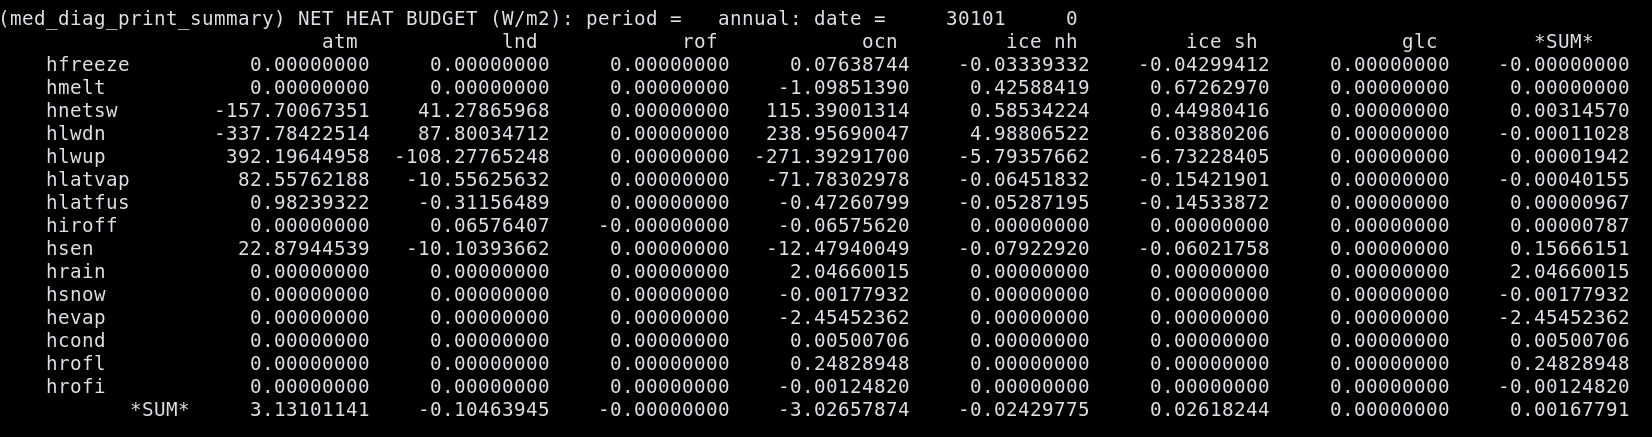

### Table vs MOM6

In [15]:
heat_table = [0.07638744, -1.09851390,115.39001314, 
              238.95690047-271.39291700, -71.78302978,
             -0.47260799, -0.06575620, -12.47940049,
             2.04660015, -0.00177932, -2.45452362, 0.00500706,
             0.24828948,-0.00124820 ]
heat_table_terms = ['hfreeze','hmelt','SW','LW','LAT_EVAP','LAT_FUS','HIROFF','SEN',
                   'hrain','hsnow','hevap','hcond','hrofl','hrofi']
water_table = [0.97668363, 23.57399664,
              1.41626608, -28.70173122, 3.00689939, 
              0.19705185]
water_table_terms = ['wmelt','rain','snow','evap','wrunoff','wfrzrof']

In [16]:
heat_mom = np.zeros(len(heat_table))
area = 4*np.pi
# frazil or hfreeze
heat_mom[0] = ((frazil*med_area).sum())/area 
# hmelt
heat_mom[1] = ((seaice_melt_heat*med_area).sum())/area 
# SW
heat_mom[2] = ((SW*med_area).sum())/area 
# LW
heat_mom[3] = ((LW*med_area).sum())/area
# latent_evap
heat_mom[4] = ((latent_evap*med_area).sum())/area
# latent_fprec_diag
heat_mom[5] = ((latent_fprec_diag*med_area).sum())/area
# latent_frunoff
heat_mom[6] = ((latent_frunoff*med_area).sum())/area
# sensible
heat_mom[7] = ((sensible*med_area).sum())/area
# hrain
heat_mom[8] = ((heat_content_lprec*med_area).sum())/area 
# hsnow
heat_mom[9] = ((heat_content_fprec*med_area).sum())/area 
# hevap
heat_mom[10] = ((heat_content_evap*med_area).sum())/area 
# hcond
heat_mom[11] = ((heat_content_cond*med_area).sum())/area 
# hrofl
heat_mom[12] = ((heat_content_lrunoff*med_area).sum())/area 
# hrofi
heat_mom[13] = ((heat_content_frunoff*med_area).sum())/area

In [17]:
print('------------------ YEAR 2 --------------------')
print('{:>10s} {:>10s} {:>10s} {:>10s}'.format('VARIABLE','MOM6','TABLE','MOM-TABLE'))
print('----------------------------------------------')
for i in range(len(heat_mom)):
    print('{:>10s} {:10.6f} {:10.6f} {:10.6f}'.format(heat_table_terms[i],
        heat_mom[i],heat_table[i],heat_mom[i]-heat_table[i]))
print('----------------------------------------------')
print('{:>10s} {:10.6f} {:10.6f} {:10.6f}'.format('SUM',
        np.sum(heat_mom),np.sum(heat_table),
        np.sum(heat_mom)-np.sum(heat_table)))

------------------ YEAR 2 --------------------
  VARIABLE       MOM6      TABLE  MOM-TABLE
----------------------------------------------
   hfreeze   0.076387   0.076387  -0.000001
     hmelt  -1.098539  -1.098514  -0.000025
        SW 115.389990 115.390013  -0.000023
        LW -32.435948 -32.436017   0.000068
  LAT_EVAP -71.782823 -71.783030   0.000207
   LAT_FUS  -0.472600  -0.472608   0.000008
    HIROFF  -0.065755  -0.065756   0.000002
       SEN -12.479282 -12.479400   0.000118
     hrain   2.046606   2.046600   0.000005
     hsnow  -0.001779  -0.001779  -0.000000
     hevap  -2.454520  -2.454524   0.000003
     hcond   0.005007   0.005007  -0.000000
     hrofl   0.248291   0.248289   0.000001
     hrofi  -0.001248  -0.001248   0.000000
----------------------------------------------
       SUM  -3.026216  -3.026579   0.000363


In [18]:
water_mom = np.zeros(len(water_table))

#water_table_terms = ['hfreeze','wmelt','rain','snow','evap','weqsaltf','wrunoff','wfrzrof']

# wmelt
water_mom[0] = ((seaice_melt*med_area).sum())/area 
# rain
water_mom[1] = ((lprec*med_area).sum())/area 
# snow
water_mom[2] = ((fprec*med_area).sum())/area 
# evap
water_mom[3] = ((evap*med_area).sum())/area 
# lrunoff
water_mom[4] = ((lrunoff*med_area).sum())/area
# frunoff
water_mom[5] = ((frunoff*med_area).sum())/area

In [19]:
print('------------------ YEAR 2 --------------------')
print('{:>10s} {:>10s} {:>10s} {:>10s}'.format('VARIABLE','MOM6','TABLE','MOM-TABLE'))
print('----------------------------------------------')
for i in range(len(water_mom)):
    print('{:>10s} {:10.6f} {:10.6f} {:10.6f}'.format(water_table_terms[i],
        water_mom[i],water_table[i],water_mom[i]-water_table[i]))
print('----------------------------------------------')
print('{:>10s} {:10.6f} {:10.6f} {:10.6f}'.format('SUM',
        np.sum(water_mom),np.sum(water_table),
        np.sum(water_mom)-np.sum(water_table)))

------------------ YEAR 2 --------------------
  VARIABLE       MOM6      TABLE  MOM-TABLE
----------------------------------------------
     wmelt   0.976805   0.976684   0.000122
      rain  23.573988  23.573997  -0.000009
      snow   1.416243   1.416266  -0.000023
      evap -28.701649 -28.701731   0.000083
   wrunoff   3.006916   3.006899   0.000017
   wfrzrof   0.197047   0.197052  -0.000005
----------------------------------------------
       SUM   0.469351   0.469166   0.000184


### Change in heat content check

dtomint = tomint[n] - tomint[n0]
dt      = time[n] - time[n0]
lhs     = cp * area * dtomint / dt

In [27]:
# year 2
hi = 1.9697723001177393E+25 
hf = 1.9648938107905527E+25

In [28]:
n = 1 # year
heat = (hf-hi) / (grd.area_t.sum() * 3600. * 24 * 365 * n)
print('Change in heat from MOM log is {} W/m2'.format(heat))
print(heat)

Change in heat from MOM log is -3.059420411155107 W/m2
-3.059420411155107


In [29]:
area_ocean = grd.area_t.sum()
(((frazil+seaice_melt_heat+SW+LW+latent_evap+latent_fprec_diag+
  latent_frunoff+sensible+heat_content_lprec+heat_content_fprec+
  heat_content_evap+heat_content_cond+heat_content_lrunoff+heat_content_frunoff)*grd.area_t).sum())/area_ocean 

-3.053028191141143

### Figures

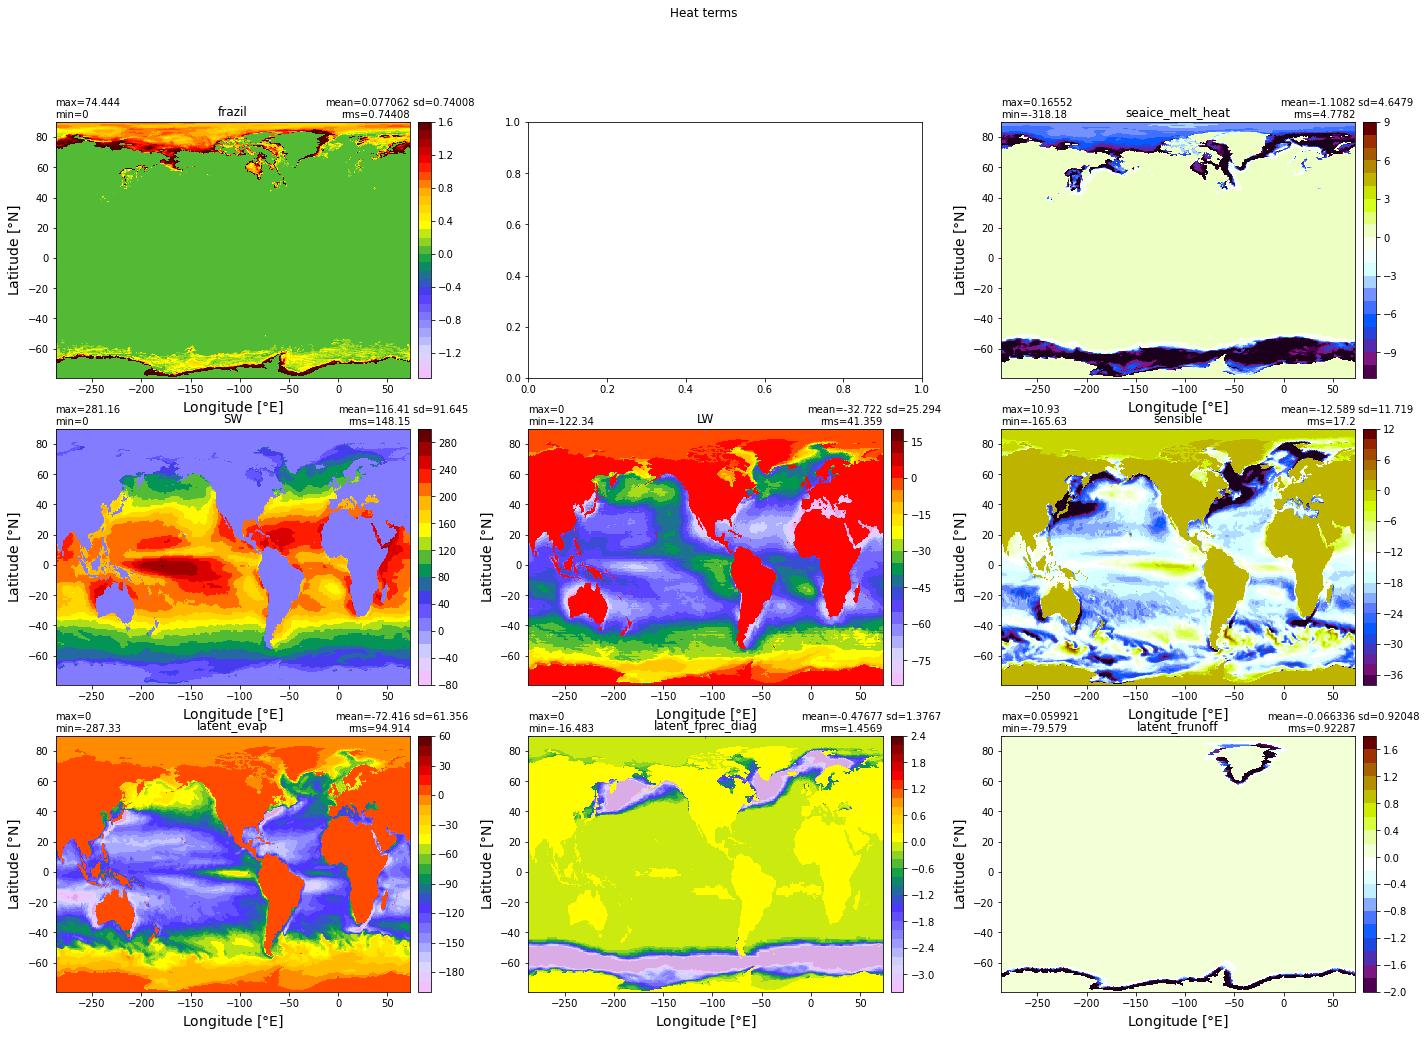

In [25]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,16))
ax1 = ax.flatten()
plt.suptitle('Heat terms')
xyplot(frazil,grd.geolon, grd.geolat, grd.area_t, axis=ax1[0], title='frazil')
#xyplot(heat_content_icemelt,grd.geolon, grd.geolat, grd.area_t, axis=ax1[1], title='heat_content_icemelt')
xyplot(seaice_melt_heat,grd.geolon, grd.geolat, grd.area_t, axis=ax1[2], title='seaice_melt_heat')

xyplot(SW,grd.geolon, grd.geolat, grd.area_t, axis=ax1[3], title='SW')
xyplot(LW,grd.geolon, grd.geolat, grd.area_t, axis=ax1[4], title='LW')
xyplot(sensible,grd.geolon, grd.geolat, grd.area_t, axis=ax1[5], title='sensible')

xyplot(latent_evap,grd.geolon, grd.geolat, grd.area_t, axis=ax1[6], title='latent_evap')
xyplot(latent_fprec_diag,grd.geolon, grd.geolat, grd.area_t, axis=ax1[7], title='latent_fprec_diag')
xyplot(latent_frunoff,grd.geolon, grd.geolat, grd.area_t, axis=ax1[8], title='latent_frunoff')

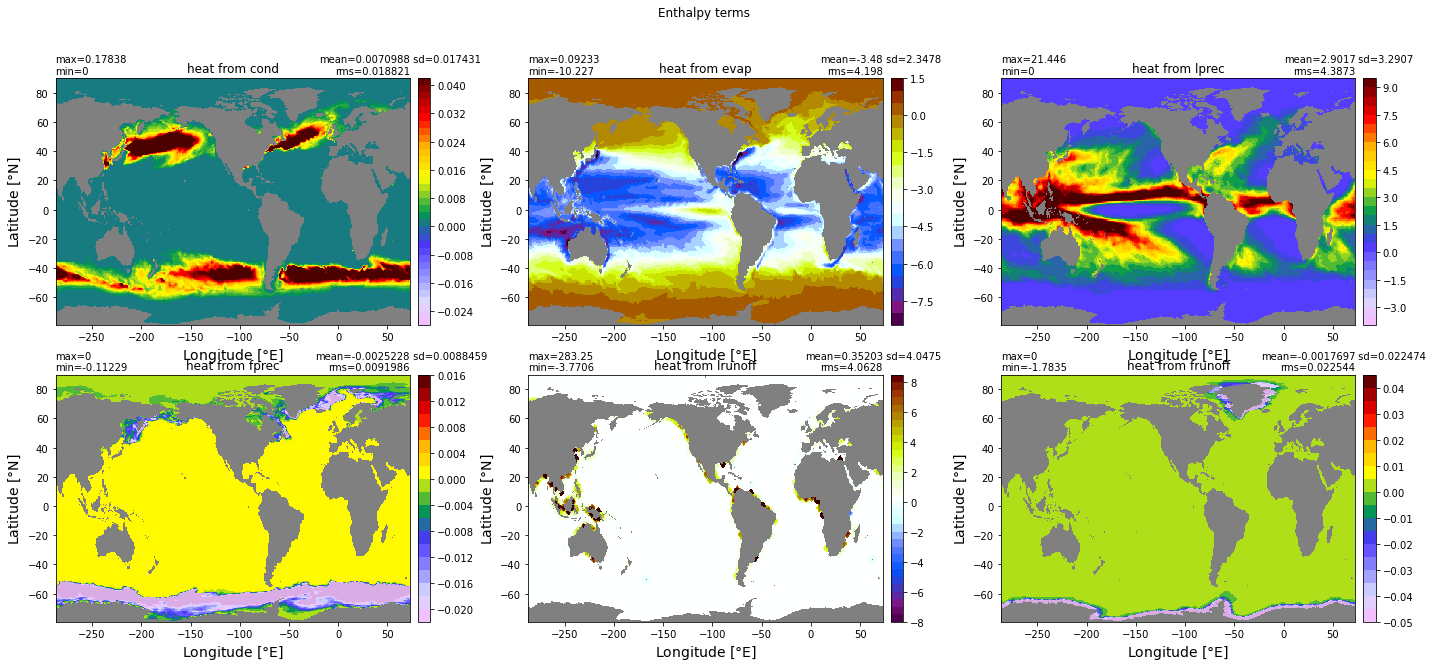

In [32]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24,10))
ax1 = ax.flatten()
plt.suptitle('Enthalpy terms')

xyplot(heat_content_cond,grd.geolon, grd.geolat, grd.area_t, axis=ax1[0], title='heat from cond')
xyplot(heat_content_evap,grd.geolon, grd.geolat, grd.area_t, axis=ax1[1], title='heat from evap')
xyplot(heat_content_lprec,grd.geolon, grd.geolat, grd.area_t, axis=ax1[2], title='heat from lprec')

xyplot(heat_content_fprec,grd.geolon, grd.geolat, grd.area_t, axis=ax1[3], title='heat from fprec')
xyplot(heat_content_lrunoff,grd.geolon, grd.geolat, grd.area_t, axis=ax1[4], title='heat from lrunoff')
xyplot(heat_content_frunoff,grd.geolon, grd.geolat, grd.area_t, axis=ax1[5], title='heat from frunoff')

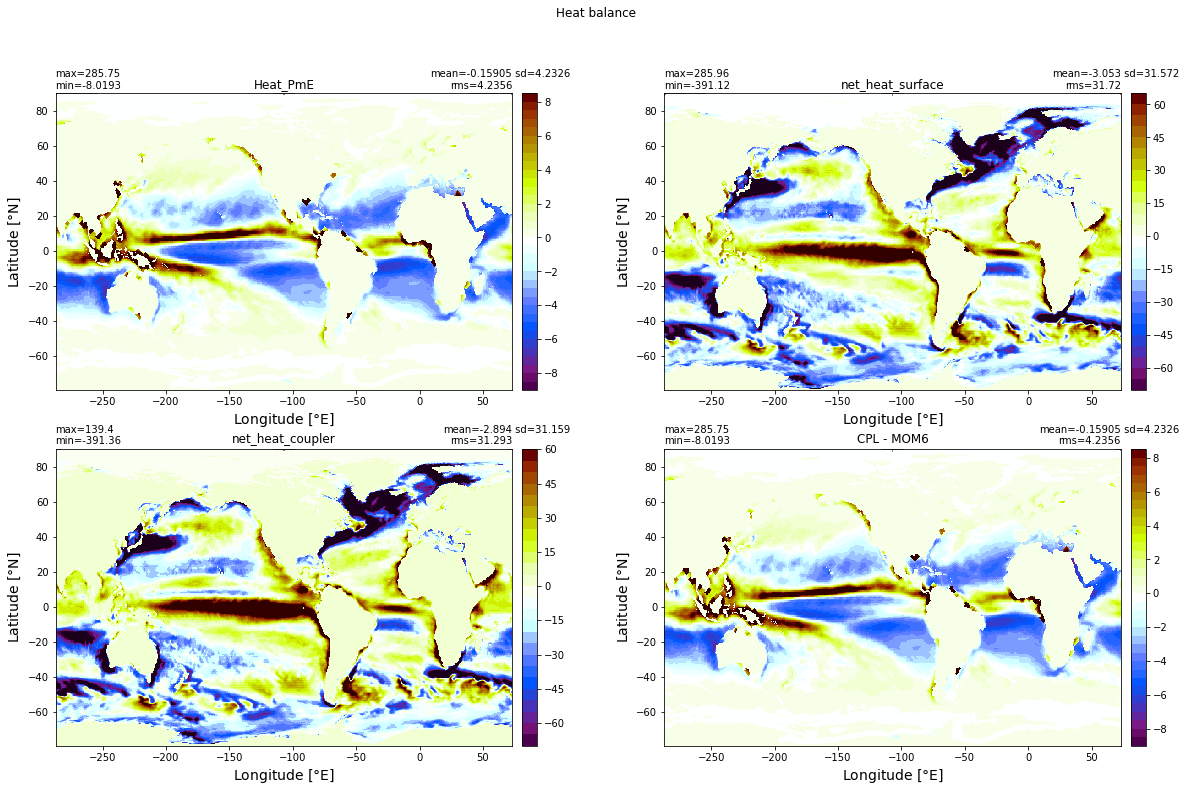

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
ax1 = ax.flatten()
plt.suptitle('Heat balance')

xyplot(Heat_PmE,grd.geolon, grd.geolat, grd.area_t, axis=ax1[0], title='Heat_PmE')
xyplot(net_heat_surface,grd.geolon, grd.geolat, grd.area_t, axis=ax1[1], title='net_heat_surface')
xyplot(net_heat_coupler1+frazil,grd.geolon, grd.geolat, grd.area_t, axis=ax1[2], title='net_heat_coupler')
xyplot(net_heat_surface-(net_heat_coupler1+frazil),grd.geolon, grd.geolat, grd.area_t, axis=ax1[3], title='CPL - MOM6')